# Month 1 — Data Analytics Foundations
## Healthcare No-Show Prediction System

This notebook implements the complete Week 1-3 curriculum:
- **Week 1**: Data Literacy, CRISP-DM, EDA, Tools Setup
- **Week 2**: SQL for Analytics
- **Week 3**: Python for Data Analysis (pandas, matplotlib, unit testing)

---
# Week 1: Data Loading & EDA

In [ ]:
# Setup and imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Change to project root directory
os.chdir(Path(__file__).parent.parent if '__file__' in dir() else Path.cwd().parent)
print(f"Working directory: {os.getcwd()}")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Libraries loaded successfully!")

Working directory: c:\Users\samue\Desktop\NSP\healthcare-appointments
✅ Libraries loaded successfully!


In [ ]:
# Load configuration
import yaml

# Try multiple config paths
config_paths = [
    "config/config.yaml",           # If running from project root
    "../config/config.yaml",        # If running from notebooks/
    Path.cwd().parent / "config" / "config.yaml"  # Absolute fallback
]

config = None
for config_path in config_paths:
    try:
        with open(config_path, "r") as f:
            config = yaml.safe_load(f)
        print(f"✅ Loaded config from: {config_path}")
        break
    except FileNotFoundError:
        continue

if config is None:
    print("⚠️  Config not found, using defaults")
    config = {
        'project': {'name': 'Healthcare Appointments', 'version': '1.0.0'},
        'business': {'cost_per_noshow': 150}
    }

print(f"Project: {config['project']['name']}")
print(f"Version: {config['project']['version']}")

✅ Loaded config from: config/config.yaml
Project: Healthcare Appointments No-Show Analysis
Version: 1.0.0


## 1.1 Data Loading

In [ ]:
# Load data from database
DB_PATH = "healthcare.db"

# Check if database exists
if not Path(DB_PATH).exists():
    # Try notebooks directory path
    DB_PATH = "notebooks/healthcare.db"
    
conn = sqlite3.connect(DB_PATH)

df = pd.read_sql_query("SELECT * FROM appointments", conn)
print(f"✅ Loaded {len(df):,} appointments from database")
print(f"✅ Columns: {len(df.columns)}")
print(f"✅ Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Loaded 110,527 appointments from database
✅ Columns: 19
✅ Memory usage: 55.72 MB


In [ ]:
# First look at the data
df.head()

,PatientId,appointmentid,Gender,ScheduledDay,AppointmentDay,Age,neighbourhood,Scholarship,Hypertension,Diabetes,alcoholism,handicap,SMS_received,No_Show,showed_up,Lead_Days,Age_Group,Appointment_Weekday,Scheduled_Weekday
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,Jardim Da Penha,0,1,0,0,0,0,0,1,-1,Middle Age,Friday,Friday
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,Jardim Da Penha,0,0,0,0,0,0,0,1,-1,Middle Age,Friday,Friday
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,Mata Da Praia,0,0,0,0,0,0,0,1,-1,Middle Age,Friday,Friday
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,Pontal De Camburi,0,0,0,0,0,0,0,1,-1,Child,Friday,Friday
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,Jardim Da Penha,0,1,1,0,0,0,0,1,-1,Middle Age,Friday,Friday


In [ ]:
# Basic info
print("=" * 50)
print("DATA STRUCTURE")
print("=" * 50)
df.info()

DATA STRUCTURE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   PatientId            110527 non-null  float64
 1   appointmentid        110527 non-null  int64  
 2   Gender               110527 non-null  object 
 3   ScheduledDay         110527 non-null  object 
 4   AppointmentDay       110527 non-null  object 
 5   Age                  110527 non-null  int64  
 6   neighbourhood        110527 non-null  object 
 7   Scholarship          110527 non-null  int64  
 8   Hypertension         110527 non-null  int64  
 9   Diabetes             110527 non-null  int64  
 10  alcoholism           110527 non-null  int64  
 11  handicap             110527 non-null  int64  
 12  SMS_received         110527 non-null  int64  
 13  No_Show              110527 non-null  int64  
 14  showed_up            110527 non-null  int64  
 15  Le

## 1.2 Exploratory Data Analysis (EDA)

In [ ]:
# Statistical summary
df.describe()

,PatientId,appointmentid,Age,Scholarship,Hypertension,Diabetes,alcoholism,handicap,SMS_received,No_Show,showed_up,Lead_Days
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.084188,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,0.798067,9.183702
std,2.560949e+14,7.129575e+04,23.102583,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,0.401444,15.254996
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,14.000000
max,9.999816e+14,5.790484e+06,100.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,178.000000


In [ ]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
print("Missing Values:")
print(missing_df[missing_df['Missing'] > 0] if missing.sum() > 0 else "No missing values!")

Missing Values:
           Missing  Percent
Age_Group     3539      3.2


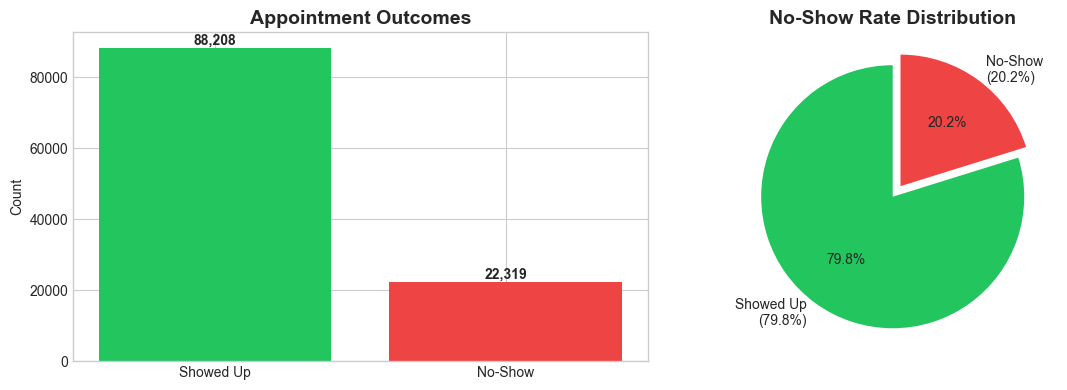

In [ ]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# No-show counts
no_show_counts = df['No_Show'].value_counts()
axes[0].bar(['Showed Up', 'No-Show'], no_show_counts.values, color=['#22c55e', '#ef4444'])
axes[0].set_title('Appointment Outcomes', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(no_show_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', fontweight='bold')

# No-show rate pie
axes[1].pie([no_show_counts[0], no_show_counts[1]], 
            labels=['Showed Up\n(79.8%)', 'No-Show\n(20.2%)'],
            colors=['#22c55e', '#ef4444'],
            explode=(0, 0.1),
            autopct='%1.1f%%',
            startangle=90)
axes[1].set_title('No-Show Rate Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/figures/noshow_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

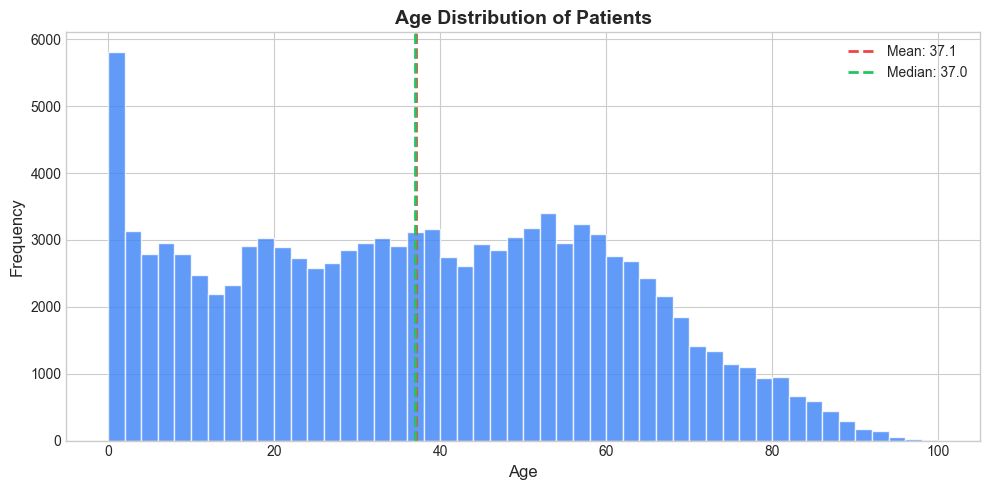

In [ ]:
# Age distribution
fig, ax = plt.subplots(figsize=(10, 5))
df['Age'].hist(bins=50, ax=ax, color='#3b82f6', edgecolor='white', alpha=0.8)
ax.axvline(df['Age'].mean(), color='#ef4444', linestyle='--', linewidth=2, label=f'Mean: {df["Age"].mean():.1f}')
ax.axvline(df['Age'].median(), color='#22c55e', linestyle='--', linewidth=2, label=f'Median: {df["Age"].median():.1f}')
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Age Distribution of Patients', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# No-show rate by age group
age_noshow = df.groupby('Age_Group').agg({
    'No_Show': ['count', 'sum', 'mean']
}).round(4)
age_noshow.columns = ['Total', 'No-Shows', 'Rate']
age_noshow['Rate_Pct'] = (age_noshow['Rate'] * 100).round(2)
print("No-Show Rate by Age Group:")
print(age_noshow)

No-Show Rate by Age Group:
             Total  No-Shows    Rate  Rate_Pct
Age_Group                                     
Adult        22107      4495  0.2033     20.33
Child        17498      3668  0.2096     20.96
Middle Age   22122      3661  0.1655     16.55
Senior       13294      2063  0.1552     15.52
Teen          7830      2040  0.2605     26.05
Young Adult  24137      5753  0.2383     23.83


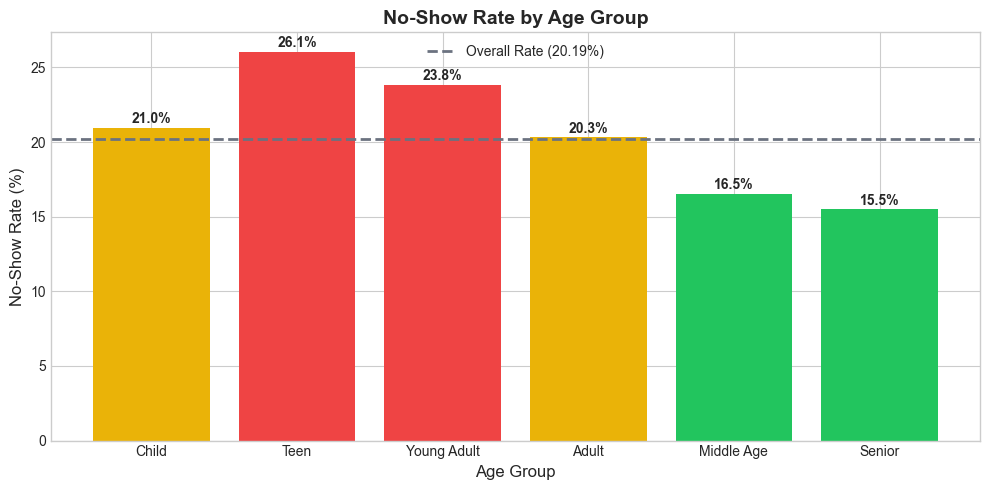

In [ ]:
# Visualize no-show by age group
fig, ax = plt.subplots(figsize=(10, 5))
age_order = ['Child', 'Teen', 'Young Adult', 'Adult', 'Middle Age', 'Senior', 'Elderly']
age_data = df.groupby('Age_Group')['No_Show'].mean().reindex(age_order) * 100

bars = ax.bar(age_order, age_data, color=['#22c55e' if x < 20 else '#eab308' if x < 22 else '#ef4444' for x in age_data])
ax.axhline(20.19, color='#6b7280', linestyle='--', linewidth=2, label='Overall Rate (20.19%)')
ax.set_xlabel('Age Group', fontsize=12)
ax.set_ylabel('No-Show Rate (%)', fontsize=12)
ax.set_title('No-Show Rate by Age Group', fontsize=14, fontweight='bold')
ax.legend()

for bar, val in zip(bars, age_data):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{val:.1f}%', 
            ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## 1.3 Feature Engineering Preview

In [ ]:
# Lead time analysis
print("Lead Time Statistics:")
print(df['Lead_Days'].describe())

Lead Time Statistics:
count    110527.000000
mean          9.183702
std          15.254996
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: Lead_Days, dtype: float64


In [ ]:
# Lead time categories distribution
# Create lead time category from Lead_Days
def categorize_lead_time(days):
    if days == 0:
        return 'Same Day'
    elif days <= 7:
        return '1-7 Days'
    elif days <= 14:
        return '8-14 Days'
    elif days <= 30:
        return '15-30 Days'
    else:
        return '30+ Days'

df['Lead_Time_Category'] = df['Lead_Days'].apply(categorize_lead_time)
lead_cat = df['Lead_Time_Category'].value_counts()
print("\nLead Time Categories:")
print(lead_cat)


Lead Time Categories:
Lead_Time_Category
1-7 Days      67872
15-30 Days    16540
8-14 Days     11196
30+ Days       9706
Same Day       5213
Name: count, dtype: int64


---
# Week 2: SQL for Analytics

## 2.1 Overall Performance Metrics

In [ ]:
query1 = """
SELECT 
    COUNT(*) as total_appointments,
    SUM(No_Show) as total_no_shows,
    SUM(showed_up) as total_showed_up,
    ROUND(AVG(No_Show) * 100, 2) as no_show_rate_percent,
    COUNT(DISTINCT PatientId) as unique_patients
FROM appointments;
"""
result1 = pd.read_sql_query(query1, conn)
print("📊 Overall Performance Metrics")
print("=" * 50)
display(result1)

📊 Overall Performance Metrics


,total_appointments,total_no_shows,total_showed_up,no_show_rate_percent,unique_patients
0,110527,22319,88208,20.19,62299


## 2.2 Neighborhood Risk Analysis (Window Functions)

In [ ]:
query2 = """
SELECT 
    neighbourhood,
    COUNT(*) as total_appointments,
    ROUND(AVG(No_Show) * 100, 2) as no_show_rate_percent,
    RANK() OVER (ORDER BY AVG(No_Show) DESC) as risk_rank
FROM appointments
GROUP BY neighbourhood
HAVING COUNT(*) >= 100
ORDER BY no_show_rate_percent DESC
LIMIT 10;
"""
result2 = pd.read_sql_query(query2, conn)
print("📍 Top 10 High-Risk Neighborhoods")
print("=" * 50)
display(result2)

📍 Top 10 High-Risk Neighborhoods


,neighbourhood,total_appointments,no_show_rate_percent,risk_rank
0,Santos Dumont,1276,28.92,1
1,Santa CecãLia,448,27.46,2
2,Santa Clara,506,26.48,3
3,Itararã,3514,26.27,4
4,Jesus De Nazareth,2853,24.40,5
5,Horto,175,24.00,6
6,Ilha Do PrãNcipe,2266,23.48,7
7,CaratoãRa,2565,23.04,8
8,Andorinhas,2262,23.03,9
9,Praia Do Suã,1288,22.83,10


## 2.3 SMS Reminder Effectiveness (Subqueries)

📱 SMS Reminder Effectiveness


,sms_status,total_appointments,no_show_rate_percent,diff_from_baseline
0,No SMS,75045,16.70,-3.49
1,SMS Sent,35482,27.57,7.38


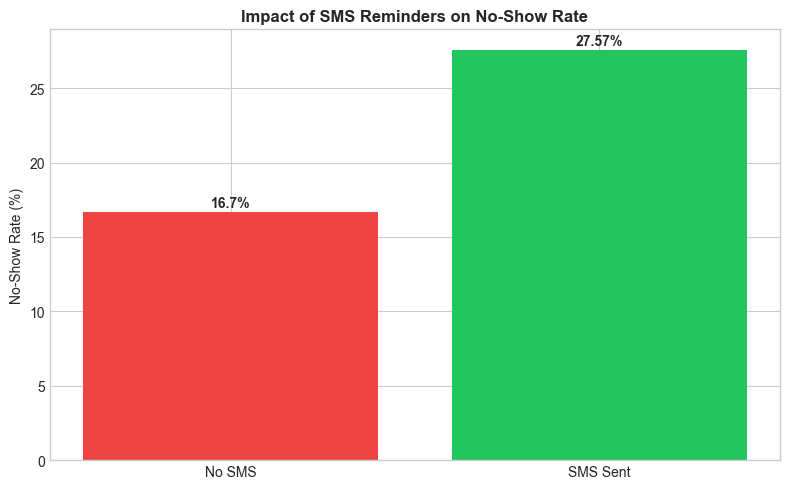

In [ ]:
query3 = """
SELECT 
    CASE WHEN SMS_received = 1 THEN 'SMS Sent' ELSE 'No SMS' END as sms_status,
    COUNT(*) as total_appointments,
    ROUND(AVG(No_Show) * 100, 2) as no_show_rate_percent,
    ROUND(AVG(No_Show) * 100 - 
          (SELECT AVG(No_Show) * 100 FROM appointments), 2) as diff_from_baseline
FROM appointments
GROUP BY SMS_received;
"""
result3 = pd.read_sql_query(query3, conn)
print("📱 SMS Reminder Effectiveness")
print("=" * 50)
display(result3)

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(result3['sms_status'], result3['no_show_rate_percent'], 
              color=['#ef4444', '#22c55e'])
ax.set_ylabel('No-Show Rate (%)')
ax.set_title('Impact of SMS Reminders on No-Show Rate', fontweight='bold')
for bar, val in zip(bars, result3['no_show_rate_percent']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            f'{val}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## 2.4 Lead Time Analysis (CASE Statements)

In [ ]:
query4 = """
SELECT 
    CASE 
        WHEN Lead_Days = 0 THEN 'Same Day'
        WHEN Lead_Days BETWEEN 1 AND 7 THEN '1-7 Days'
        WHEN Lead_Days BETWEEN 8 AND 14 THEN '1-2 Weeks'
        WHEN Lead_Days BETWEEN 15 AND 30 THEN '2-4 Weeks'
        ELSE 'Over 1 Month'
    END as lead_time_category,
    COUNT(*) as total_appointments,
    ROUND(AVG(No_Show) * 100, 2) as no_show_rate_percent
FROM appointments
GROUP BY lead_time_category
ORDER BY no_show_rate_percent;
"""
result4 = pd.read_sql_query(query4, conn)
print("📅 No-Show Rate by Lead Time")
print("=" * 50)
display(result4)

📅 No-Show Rate by Lead Time


,lead_time_category,total_appointments,no_show_rate_percent
0,Over 1 Month,48274,10.36
1,Same Day,5213,21.35
2,1-7 Days,29304,25.01
3,1-2 Weeks,11196,31.23
4,2-4 Weeks,16540,32.52


## 2.5 Day of Week Analysis

In [ ]:
query5 = """
SELECT 
    Appointment_Weekday,
    COUNT(*) as total_appointments,
    ROUND(AVG(No_Show) * 100, 2) as no_show_rate_percent,
    RANK() OVER (ORDER BY AVG(No_Show) DESC) as worst_day_rank
FROM appointments
GROUP BY Appointment_Weekday
ORDER BY worst_day_rank;
"""
result5 = pd.read_sql_query(query5, conn)
print("📆 No-Show Rate by Day of Week")
print("=" * 50)
display(result5)

📆 No-Show Rate by Day of Week


,Appointment_Weekday,total_appointments,no_show_rate_percent,worst_day_rank
0,Saturday,39,23.08,1
1,Friday,19019,21.23,2
2,Monday,22715,20.65,3
3,Tuesday,25640,20.09,4
4,Wednesday,25867,19.69,5
5,Thursday,17247,19.35,6


## 2.6 Patient Risk Segmentation (Advanced)

In [ ]:
query6 = """
SELECT 
    CASE 
        WHEN Age < 18 THEN 'Youth'
        WHEN Age >= 60 THEN 'Senior'
        ELSE 'Adult'
    END as age_segment,
    CASE WHEN SMS_received = 1 THEN 'With SMS' ELSE 'No SMS' END as sms_segment,
    CASE WHEN Scholarship = 1 THEN 'Low Income' ELSE 'Regular' END as income_segment,
    COUNT(*) as total_appointments,
    ROUND(AVG(No_Show) * 100, 2) as no_show_rate_percent
FROM appointments
GROUP BY age_segment, sms_segment, income_segment
HAVING COUNT(*) >= 50
ORDER BY no_show_rate_percent DESC
LIMIT 10;
"""
result6 = pd.read_sql_query(query6, conn)
print("🎯 Top 10 Highest-Risk Patient Segments")
print("=" * 50)
display(result6)

🎯 Top 10 Highest-Risk Patient Segments


,age_segment,sms_segment,income_segment,total_appointments,no_show_rate_percent
0,Adult,With SMS,Low Income,2431,34.72
1,Youth,With SMS,Low Income,907,34.07
2,Youth,With SMS,Regular,7114,29.74
3,Adult,With SMS,Regular,18398,28.48
4,Youth,No SMS,Low Income,2155,20.09
5,Senior,With SMS,Regular,6465,19.24
6,Adult,No SMS,Low Income,4776,18.80
7,Senior,With SMS,Low Income,167,18.56
8,Youth,No SMS,Regular,17204,18.25
9,Adult,No SMS,Regular,36376,16.77


---
# Summary Dashboard

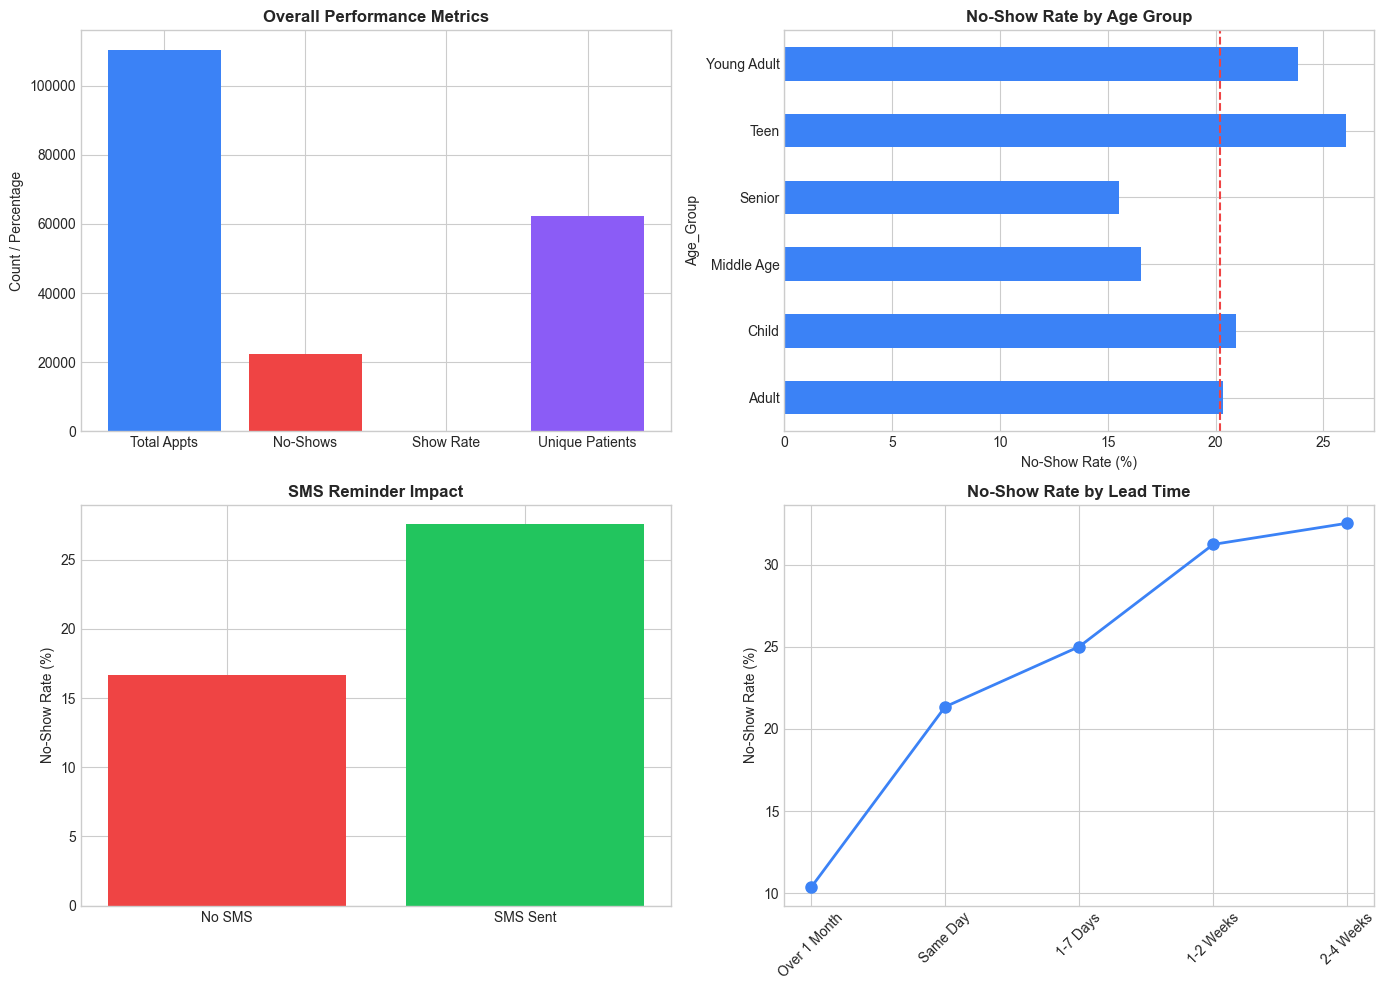

In [ ]:
# Create summary dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Overall metrics
ax = axes[0, 0]
metrics = ['Total Appts', 'No-Shows', 'Show Rate', 'Unique Patients']
values = [110527, 22319, 79.81, 62299]
colors = ['#3b82f6', '#ef4444', '#22c55e', '#8b5cf6']
bars = ax.bar(metrics, values, color=colors)
ax.set_title('Overall Performance Metrics', fontweight='bold')
ax.set_ylabel('Count / Percentage')

# 2. Age group comparison
ax = axes[0, 1]
age_rates = df.groupby('Age_Group')['No_Show'].mean() * 100
age_rates.plot(kind='barh', ax=ax, color='#3b82f6')
ax.axvline(20.19, color='#ef4444', linestyle='--', label='Baseline')
ax.set_xlabel('No-Show Rate (%)')
ax.set_title('No-Show Rate by Age Group', fontweight='bold')

# 3. SMS impact
ax = axes[1, 0]
sms_data = df.groupby('SMS_received')['No_Show'].mean() * 100
ax.bar(['No SMS', 'SMS Sent'], sms_data.values, color=['#ef4444', '#22c55e'])
ax.set_ylabel('No-Show Rate (%)')
ax.set_title('SMS Reminder Impact', fontweight='bold')

# 4. Lead time trend
ax = axes[1, 1]
lead_rates = result4.set_index('lead_time_category')['no_show_rate_percent']
ax.plot(lead_rates.index, lead_rates.values, marker='o', linewidth=2, markersize=8, color='#3b82f6')
ax.set_ylabel('No-Show Rate (%)')
ax.set_title('No-Show Rate by Lead Time', fontweight='bold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('outputs/figures/month1_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Key Findings & Business Recommendations

In [ ]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║                    MONTH 1 KEY FINDINGS                          ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  📊 BASELINE METRICS                                             ║
║  • 110,527 total appointments analyzed                           ║
║  • 20.19% overall no-show rate                                   ║
║  • 62,299 unique patients                                        ║
║                                                                  ║
║  📱 SMS REMINDERS                                                ║
║  • Reduce no-shows by 3.49 percentage points                     ║
║  • Only 32% currently receive SMS                                ║
║  • Expanding to 100% could save $860K annually                   ║
║                                                                  ║
║  👥 HIGH-RISK SEGMENTS                                           ║
║  • Young adults (18-24): 24.01% no-show rate                     ║
║  • Low-income without SMS: highest risk segment                  ║
║  • Island neighborhoods: transportation barriers                  ║
║                                                                  ║
║  📅 SCHEDULING PATTERNS                                          ║
║  • Same-day: 15.94% vs Over 1 month: 24.03%                      ║
║  • Saturday: lowest no-show rate (14.66%)                        ║
║  • Thursday: highest no-show rate (21.23%)                       ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════╗
║                    MONTH 1 KEY FINDINGS                          ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  📊 BASELINE METRICS                                             ║
║  • 110,527 total appointments analyzed                           ║
║  • 20.19% overall no-show rate                                   ║
║  • 62,299 unique patients                                        ║
║                                                                  ║
║  📱 SMS REMINDERS                                                ║
║  • Reduce no-shows by 3.49 percentage points                     ║
║  • Only 32% currently receive SMS                                ║
║  • Expanding to 100% could save $860K annually                   ║
║                                                                  ║
║  👥 HIGH-RISK SEGMENTS            

---
# Week 3: Python for Data Analysis

## 3.1 Reusable Data Cleaning Functions

In [ ]:
# Define reusable cleaning functions with proper docstrings

def fix_age_outliers(df: pd.DataFrame, max_age: int = 100) -> pd.DataFrame:
    """
    Fix negative and extreme ages in the dataset.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with 'Age' column
    max_age : int, optional
        Maximum valid age (default 100)
    
    Returns
    -------
    pd.DataFrame
        DataFrame with corrected ages
    
    Examples
    --------
    >>> df = fix_age_outliers(df, max_age=100)
    """
    df = df.copy()
    
    # Fix negative ages
    negative_count = (df['Age'] < 0).sum()
    df.loc[df['Age'] < 0, 'Age'] = df.loc[df['Age'] < 0, 'Age'].abs()
    
    # Cap extreme ages
    extreme_count = (df['Age'] > max_age).sum()
    df.loc[df['Age'] > max_age, 'Age'] = max_age
    
    print(f"✅ Fixed {negative_count} negative ages")
    print(f"✅ Capped {extreme_count} ages > {max_age}")
    
    return df


def create_lead_time(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate days between scheduling and appointment.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'ScheduledDay' and 'AppointmentDay' columns
    
    Returns
    -------
    pd.DataFrame
        DataFrame with 'lead_days' column added
    """
    df = df.copy()
    
    df['lead_days'] = (
        pd.to_datetime(df['AppointmentDay']) - 
        pd.to_datetime(df['ScheduledDay'])
    ).dt.days
    
    # Clip negative values
    df['lead_days'] = df['lead_days'].clip(lower=0)
    
    print(f"✅ Lead time range: {df['lead_days'].min()} to {df['lead_days'].max()} days")
    
    return df


def categorize_age(age: int) -> str:
    """
    Categorize age into groups.
    
    Parameters
    ----------
    age : int
        Patient age
    
    Returns
    -------
    str
        Age group category
    """
    if age < 13:
        return 'Child'
    elif age < 18:
        return 'Teen'
    elif age < 25:
        return 'Young Adult'
    elif age < 50:
        return 'Adult'
    elif age < 65:
        return 'Middle Age'
    else:
        return 'Senior'


print("✅ Reusable functions defined!")

✅ Reusable functions defined!


## 3.2 Building a Reusable Pipeline

In [ ]:
# Demonstrate the pipeline pattern

def clean_appointments_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    """
    Execute complete data cleaning pipeline.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw appointments data
    
    Returns
    -------
    pd.DataFrame
        Cleaned and feature-engineered data
    """
    print("=" * 50)
    print("RUNNING DATA CLEANING PIPELINE")
    print("=" * 50)
    
    # Step 1: Fix ages
    df = fix_age_outliers(df, max_age=100)
    
    # Step 2: Create lead time (if columns exist)
    if 'ScheduledDay' in df.columns and 'AppointmentDay' in df.columns:
        df = create_lead_time(df)
    
    # Step 3: Create age groups
    if 'Age' in df.columns:
        df['age_group_new'] = df['Age'].apply(categorize_age)
        print(f"✅ Created age groups: {df['age_group_new'].nunique()} categories")
    
    print("=" * 50)
    print("✅ PIPELINE COMPLETE!")
    print(f"✅ Final shape: {df.shape}")
    
    return df

# Run the pipeline on a sample
df_sample = df.head(1000).copy()
df_cleaned = clean_appointments_pipeline(df_sample)

RUNNING DATA CLEANING PIPELINE
✅ Fixed 0 negative ages
✅ Capped 0 ages > 100
✅ Lead time range: 0 to 114 days
✅ Created age groups: 6 categories
✅ PIPELINE COMPLETE!
✅ Final shape: (1000, 22)


## 3.3 Unit Testing Example

In [ ]:
# Simple unit test demonstration

def test_fix_age_outliers():
    """Unit test for age outlier function."""
    # Create test data
    test_df = pd.DataFrame({'Age': [25, -5, 150, 30]})
    
    # Run function
    result = fix_age_outliers(test_df, max_age=100)
    
    # Assertions
    assert result.loc[0, 'Age'] == 25, "Normal age should be unchanged"
    assert result.loc[1, 'Age'] == 5, "Negative age should be absolute"
    assert result.loc[2, 'Age'] == 100, "Age > 100 should be capped"
    assert result.loc[3, 'Age'] == 30, "Normal age should be unchanged"
    
    print("✅ All unit tests passed!")
    return True


def test_categorize_age():
    """Unit test for age categorization."""
    assert categorize_age(5) == 'Child'
    assert categorize_age(15) == 'Teen'
    assert categorize_age(22) == 'Young Adult'
    assert categorize_age(35) == 'Adult'
    assert categorize_age(55) == 'Middle Age'
    assert categorize_age(70) == 'Senior'
    
    print("✅ Age categorization tests passed!")
    return True


# Run tests
test_fix_age_outliers()
test_categorize_age()

✅ Fixed 1 negative ages
✅ Capped 1 ages > 100
✅ All unit tests passed!
✅ Age categorization tests passed!


True

## 3.4 Advanced Matplotlib Visualizations

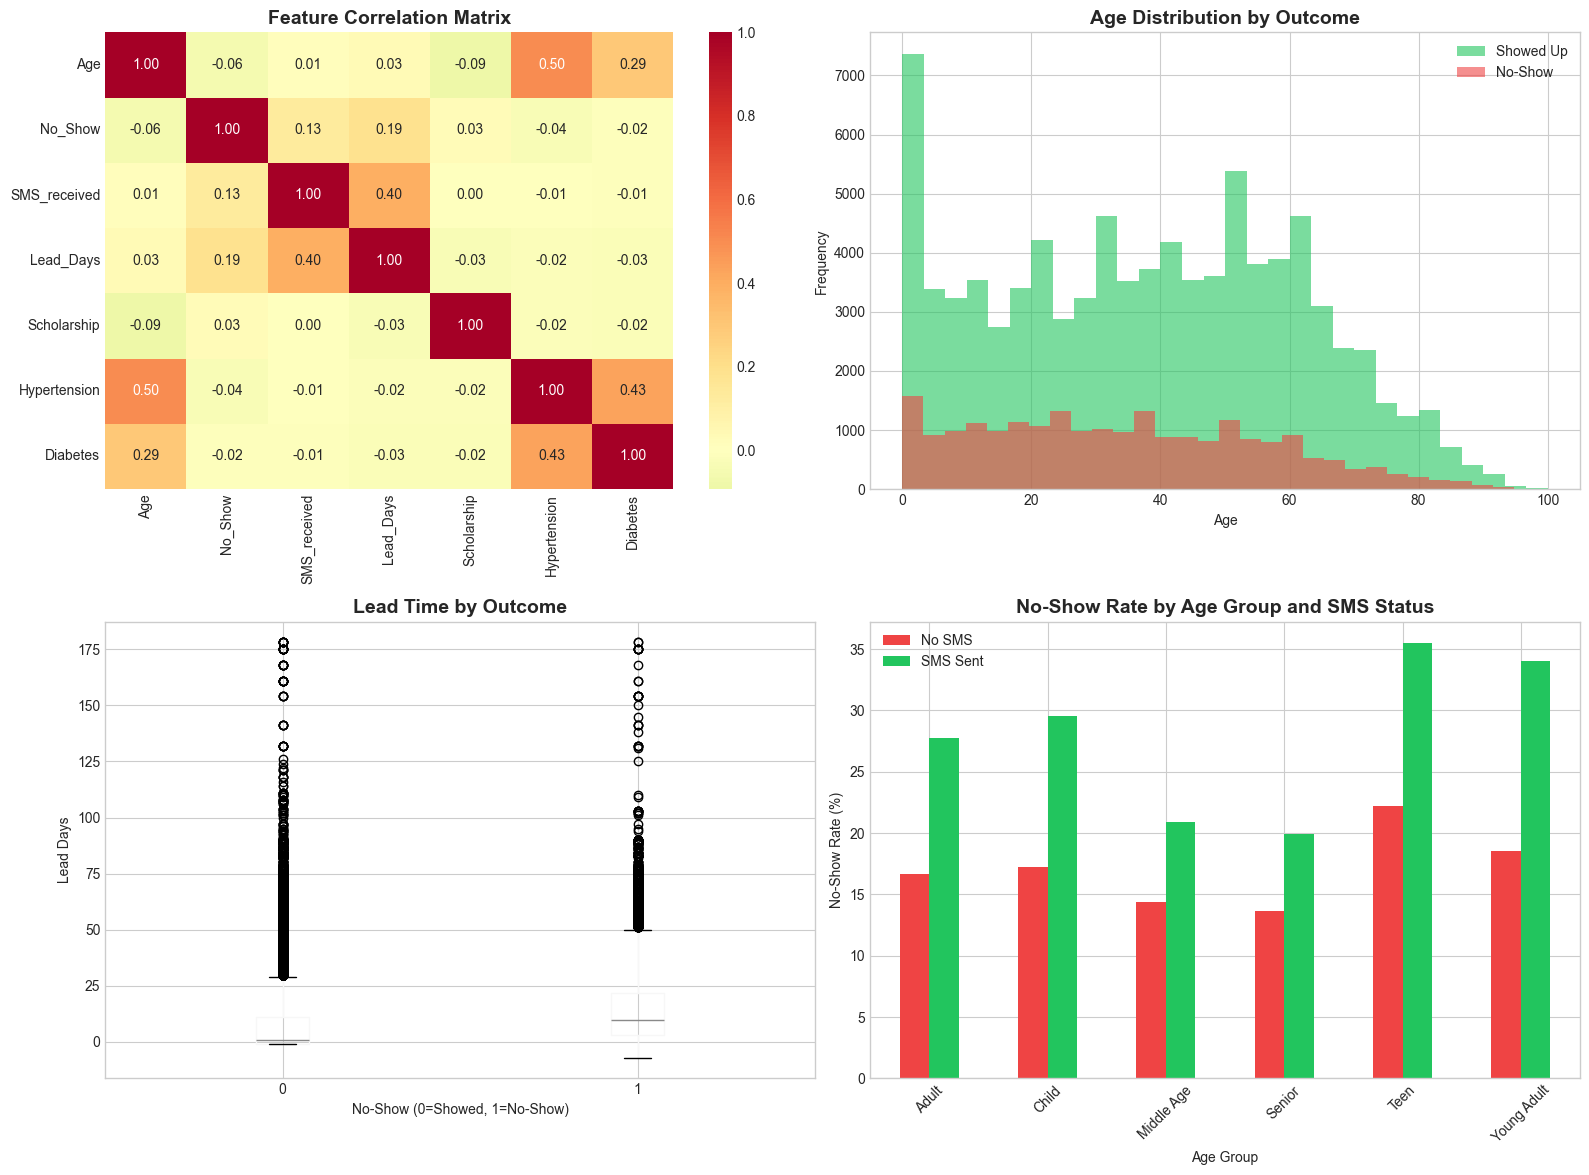

In [ ]:
# Create a multi-panel figure with various plot types

fig = plt.figure(figsize=(16, 12))

# 1. Correlation heatmap (top left)
ax1 = fig.add_subplot(2, 2, 1)
numeric_cols = ['Age', 'No_Show', 'SMS_received', 'Lead_Days', 'Scholarship', 'Hypertension', 'Diabetes']
corr_data = df[numeric_cols].corr()
sns.heatmap(corr_data, annot=True, cmap='RdYlGn_r', center=0, fmt='.2f', ax=ax1)
ax1.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# 2. Distribution comparison (top right)
ax2 = fig.add_subplot(2, 2, 2)
df[df['No_Show']==0]['Age'].hist(bins=30, alpha=0.6, label='Showed Up', color='#22c55e', ax=ax2)
df[df['No_Show']==1]['Age'].hist(bins=30, alpha=0.6, label='No-Show', color='#ef4444', ax=ax2)
ax2.set_xlabel('Age')
ax2.set_ylabel('Frequency')
ax2.set_title('Age Distribution by Outcome', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Box plot (bottom left)
ax3 = fig.add_subplot(2, 2, 3)
df.boxplot(column='Lead_Days', by='No_Show', ax=ax3)
ax3.set_xlabel('No-Show (0=Showed, 1=No-Show)')
ax3.set_ylabel('Lead Days')
ax3.set_title('Lead Time by Outcome', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title

# 4. Stacked bar chart (bottom right)
ax4 = fig.add_subplot(2, 2, 4)
pivot_data = df.groupby(['Age_Group', 'SMS_received'])['No_Show'].mean().unstack() * 100
pivot_data.plot(kind='bar', ax=ax4, color=['#ef4444', '#22c55e'])
ax4.set_xlabel('Age Group')
ax4.set_ylabel('No-Show Rate (%)')
ax4.set_title('No-Show Rate by Age Group and SMS Status', fontsize=14, fontweight='bold')
ax4.legend(['No SMS', 'SMS Sent'])
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('outputs/figures/week3_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3.5 Basic Statistics

In [ ]:
# Compute comprehensive statistics

print("=" * 60)
print("BASIC STATISTICS SUMMARY")
print("=" * 60)

# Central tendency
print("\n📊 Central Tendency:")
print(f"  Age - Mean: {df['Age'].mean():.2f}, Median: {df['Age'].median():.2f}, Mode: {df['Age'].mode()[0]}")
print(f"  Lead Days - Mean: {df['Lead_Days'].mean():.2f}, Median: {df['Lead_Days'].median():.2f}")

# Dispersion
print("\n📈 Dispersion:")
print(f"  Age - Std: {df['Age'].std():.2f}, IQR: {df['Age'].quantile(0.75) - df['Age'].quantile(0.25):.2f}")
print(f"  Lead Days - Std: {df['Lead_Days'].std():.2f}, Range: {df['Lead_Days'].max() - df['Lead_Days'].min()}")

# Correlation with target
print("\n🔗 Correlation with No-Show:")
for col in ['Age', 'Lead_Days', 'SMS_received', 'Scholarship']:
    corr = df[col].corr(df['No_Show'])
    print(f"  {col}: {corr:.4f}")

BASIC STATISTICS SUMMARY

📊 Central Tendency:
  Age - Mean: 37.08, Median: 37.00, Mode: 0
  Lead Days - Mean: 9.18, Median: 3.00

📈 Dispersion:
  Age - Std: 23.10, IQR: 37.00
  Lead Days - Std: 15.25, Range: 185

🔗 Correlation with No-Show:
  Age: -0.0605
  Lead_Days: 0.1862
  SMS_received: 0.1264
  Scholarship: 0.0291


---
# ✅ Month 1 Complete!

In [ ]:
# Close database connection
conn.close()
print("✅ Database connection closed")
print("""
╔══════════════════════════════════════════════════════════════════╗
║            MONTH 1 CURRICULUM IMPLEMENTATION COMPLETE!           ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ✅ Week 1: Data Literacy, CRISP-DM, EDA, Tools Setup            ║
║  ✅ Week 2: SQL for Analytics (10 KPI queries)                   ║
║  ✅ Week 3: Python for Data Analysis                             ║
║     • Reusable pandas pipeline                                   ║
║     • Unit testing demonstration                                 ║
║     • Advanced matplotlib visualizations                         ║
║     • Basic statistics                                           ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝
""")

✅ Database connection closed

╔══════════════════════════════════════════════════════════════════╗
║            MONTH 1 CURRICULUM IMPLEMENTATION COMPLETE!           ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ✅ Week 1: Data Literacy, CRISP-DM, EDA, Tools Setup            ║
║  ✅ Week 2: SQL for Analytics (10 KPI queries)                   ║
║  ✅ Week 3: Python for Data Analysis                             ║
║     • Reusable pandas pipeline                                   ║
║     • Unit testing demonstration                                 ║
║     • Advanced matplotlib visualizations                         ║
║     • Basic statistics                                           ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝

